In [111]:
using Revise
using Plots, CSV, DataFrames, GLM, RollingFunctions
includet("model.jl")

In [112]:
#xMap = Covariates(2)
xMap = Covariates([0.8,0.8],[0.06,0.48],[1,10000],2)

Covariates([0.8, 0.8], [0.06, 0.48], [1.0, 10000.0], 2)

In [119]:
x0,y0,manipulators = generate_sample(100,xMap)
data = convert(DataFrame,x0)
data[:y] = y0 
baseline_data= copy(data)
baseline = lm(@formula(y ~ x1+x2),data)
#ols = lm(@formula(y ~ 1),data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x1 + x2

Coefficients:
               Estimate Std.Error   t value Pr(>|t|)
(Intercept)  -0.0139347 0.0479488 -0.290617   0.7720
x1             0.728599 0.0622484   11.7047   <1e-19
x2             0.114875 0.0606057   1.89545   0.0610


In [122]:
epochs = 20
N=5000
model = baseline 
mse = zeros(epochs)
mse[1] = mean((data[:y] .- predict(model,data)).^2) 
for t in 2:epochs
    x,y = generate_sample(N,xMap,false)
    data_new = convert(DataFrame,x)
    data_new[:y] = y 
    mse[t] = mean((data_new[:y] .- predict(model,data_new)).^2) 
    #update model for next time 
    data = vcat(data,data_new)
    model = lm(@formula(y ~ x1+x2),data)
end 

epochs = 20
N=5000
model = baseline 
mse_dyn = copy(mse)
mse_dyn[1] = mean((data[:y] .- predict(model,data)).^2) 
for t in 2:epochs
    x,y = generate_sample(N,xMap)
    data_new = convert(DataFrame,x)
    data_new[:y] = y 
    mse_dyn[t] = mean((data_new[:y] .- predict(model,data_new)).^2) 
    #update model for next time 
    data = vcat(data,data_new)
    #model = lm(@formula(y ~ x1+x2),data)
end 

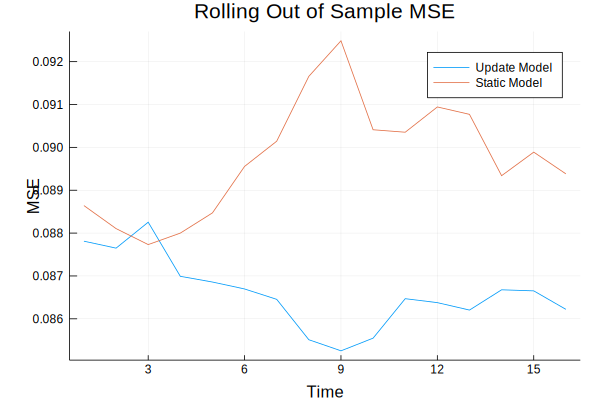

In [124]:
mse_stat = rollmean(mse[1:length(mse)],5)
mse_dp = rollmean(mse_dyn[1:length(mse_dyn)],5)
plot([mse_stat,mse_dp],title="Rolling Out of Sample MSE",xlabel="Time",ylabel="MSE",label=["Update Model","Static Model"])
#savefig("mse_stat_dyn.pdf")

In [165]:
epochs = 100
N=1000
model = baseline 
data = copy(baseline_data) 
mse = zeros(epochs)
manips = zeros(epochs)
mse[1] = mean((baseline_data[:y] .- predict(baseline,baseline_data)).^2) 
for t in 2:epochs
    x,y,manips[t] = generate_sample(N,xMap,1,model)
    data_new = convert(DataFrame,x)
    data_new[:y] = y 
    mse[t] = mean((data_new[:y] .- predict(model,data_new)).^2) 
    #update model for next time 
    data = vcat(data,data_new)
    #model = lm(@formula(y ~ x1+x2),data)
end 



In [166]:
mse_no_update = copy(mse)

100-element Array{Float64,1}:
 0.08159328214971209
 0.4790006656768873 
 0.48004567661480757
 0.4748061197239915 
 0.4746235551003717 
 0.479019875055721  
 0.4675191414524703 
 0.470259843264282  
 0.4819270585596869 
 0.47386069298484745
 0.4848375766280701 
 0.48339090221079345
 0.4888846421395441 
 ⋮                  
 0.47248945221981936
 0.4792024882202762 
 0.4772513947174524 
 0.47473255755025956
 0.4828185248101796 
 0.46502028412988444
 0.47198707833562353
 0.4764128366440588 
 0.480528758372906  
 0.4750219645410973 
 0.469329618889556  
 0.47358923923246665

In [169]:
epochs = 100
N=1000
model = baseline 
data = copy(baseline_data)
mse = zeros(epochs)
coef1 = zeros(epochs)
coef2 = zeros(epochs)
manips = zeros(epochs)
mse[1] = mean((baseline_data[:y] .- predict(baseline,baseline_data)).^2) 
coef1[1]= coef(baseline)[2]
coef2[1] = coef(baseline)[3] 
for t in 2:epochs
    x,y,manips[t] = generate_sample(N,xMap,1,model)
    data_new = convert(DataFrame,x)
    data_new[:y] = y 
    mse[t] = mean((data_new[:y] .- predict(model,data_new)).^2) 
    #update model for next time 
    data = vcat(data,data_new)
    model = lm(@formula(y ~ x1+x2),data)
    coef1[t] = coef(model)[2]
    coef2[t] = coef(model)[3] 
end 

In [171]:
plot([coef1 coef2],xlabel="Time",ylabel="Derivative",label=["x1_m","x2_n"]) 
savefig("manip_coef.pdf")

In [173]:
plot([mse mse_no_update],xlabel="Time",ylabel="MSE",label=["Update Model","No Update"])
savefig("mse_manip.pdf")

In [143]:
plot(rollmean(coef2,5))

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x1 + x2

Coefficients:
              Estimate   Std.Error t value Pr(>|t|)
(Intercept)  0.0195753 0.000810807  24.143   <1e-99
x1              0.2114 0.000859833 245.862   <1e-99
x2             0.26035  0.00084494 308.128   <1e-99


In [147]:
baseline

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x1 + x2

Coefficients:
               Estimate Std.Error   t value Pr(>|t|)
(Intercept)  -0.0139347 0.0479488 -0.290617   0.7720
x1             0.728599 0.0622484   11.7047   <1e-19
x2             0.114875 0.0606057   1.89545   0.0610
